# Visual Odometry

Visual odmetry is process of determining the position and orientation of a robot by analyzing the associated camera images. This could really help donkey cars because the standard build doesn't have an odometer so there is now way to garantee a specific speed.

This notebook attempts to output the speed, change in angle. 

Much of this information is borrowed from 

In [3]:
from base import *

from shapely import geometry

### Load Images
We are going to create a map of a track so 

In [12]:
#images_folder_path = './data/fisheye_camera_calibration/'

images_folder_path = '/home/wroscoe/data/awells_pipesupply_centerline/'
img_list = glob.glob(os.path.join(images_folder_path,'*.jpg'))
print(len(img_list))

#sort list by frame number 
img_list = sorted(img_list, key=lambda x: int(x.split('/')[-1].split('_')[0]))
img_list[:10]

4069


['/home/wroscoe/data/awells_pipesupply_centerline/0_cam-image_array_.jpg',
 '/home/wroscoe/data/awells_pipesupply_centerline/1_cam-image_array_.jpg',
 '/home/wroscoe/data/awells_pipesupply_centerline/2_cam-image_array_.jpg',
 '/home/wroscoe/data/awells_pipesupply_centerline/3_cam-image_array_.jpg',
 '/home/wroscoe/data/awells_pipesupply_centerline/4_cam-image_array_.jpg',
 '/home/wroscoe/data/awells_pipesupply_centerline/5_cam-image_array_.jpg',
 '/home/wroscoe/data/awells_pipesupply_centerline/6_cam-image_array_.jpg',
 '/home/wroscoe/data/awells_pipesupply_centerline/7_cam-image_array_.jpg',
 '/home/wroscoe/data/awells_pipesupply_centerline/8_cam-image_array_.jpg',
 '/home/wroscoe/data/awells_pipesupply_centerline/9_cam-image_array_.jpg']

### Load camera properties
We calculated these in the camera calibration script.

In [13]:
K = np.array([
    [ 340.56819732,    0.        ,  307.01297403],
    [   0.        ,  319.22996275,  237.70091279],
    [   0.        ,    0.        ,    1.        ]
])


D = np. array([
    [-0.02025494],
    [ 0.00573737],
    [-0.02515587],
    [ 0.01317606]
])


#scale only the top two rows.
x_scale = .25
scales = np.array([x_scale, x_scale, 1])
Kp = (K.T *  scales).T
Kp


array([[ 85.14204933,   0.        ,  76.75324351],
       [  0.        ,  79.80749069,  59.4252282 ],
       [  0.        ,   0.        ,   1.        ]])

In [14]:
#Pull in the camera properties we calculated in the calibrate_camera notebook
w, h = img_size = default.camera_img_size
mtx = Kp

focal_length = fx, fy = mtx[0,0], mtx[1,1]
print('focal length: {}'.format(focal_length))

optical_axis_center = cx, cy = mtx[0,2], mtx[1,2]
print('optical_axis_center: {}'.format(optical_axis_center))

k1, k2, k3, k4 = D
print('distortion coefficients')
print(default.camera_dist)

focal length: (85.142049330000006, 79.807490687500007)
optical_axis_center: (76.753243507500002, 59.425228197499997)
distortion coefficients
[[ -1.65260527]
 [  5.7104838 ]
 [-23.89860722]
 [ 55.40237623]]


In [15]:
def get_key_points(img):
    #first frame
    detector = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
    prev_points = detector.detect(img)
    points = np.array([x.pt for x in prev_points], dtype=np.float32)
    return points

In [16]:
def track_key_points(prev_img, next_img, prev_points):
    
    lk_params = dict(winSize  = (21, 21),
                     criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    next_points, status, error = cv2.calcOpticalFlowPyrLK(prev_img, 
                                                          next_img, 
                                                          prev_points, 
                                                          None, 
                                                          winSize=(21, 21),
                                                          criteria =(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
                                                         )
    status = status.reshape(status.shape[0])
    prev_points = prev_points[status == 1]
    next_points = next_points[status == 1]

    return prev_points, next_points

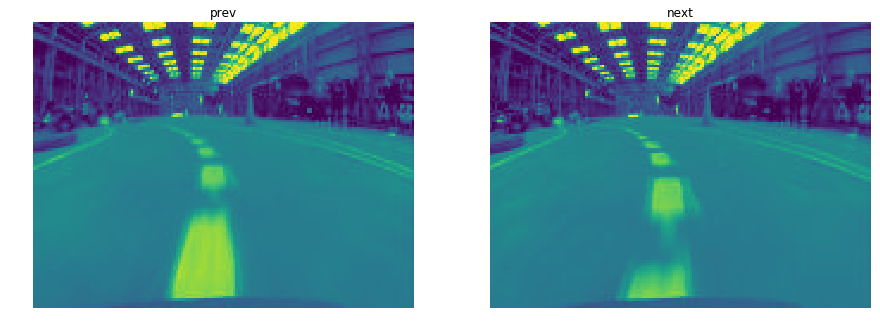

In [17]:
prev_img = cv2.imread(img_list[0], 0)
prev_points = get_key_points(prev_img)

next_img = cv2.imread(img_list[1], 0)

plot_data = [{'name': 'prev', 'array': prev_img},
             {'name': 'next', 'array': next_img}]
show_imgs(plot_data)

In [18]:
prev_points, next_points = track_key_points(prev_img, next_img, prev_points)
len(prev_points)

185

In [19]:
def calculate_possition_change(prev_img, next_img, prev_points, next_points, 
                               fx, optical_axis_center):
    """
    Calculate the relative rotaion and translation between images.
    """
    
    #filter points to only those trackable between images
    prev_points, next_points = track_key_points(prev_img, next_img, prev_points)
    
    
    E, mask = cv2.findEssentialMat(prev_points, 
                                   next_points, 
                                   focal=fx, 
                                   pp=optical_axis_center, 
                                   method=cv2.RANSAC, 
                                   prob=0.999, 
                                   threshold=1.0)
    
    _, R, t, mask = cv2.recoverPose(E, 
                                    next_points, 
                                    prev_points, 
                                    focal=fx, 
                                    pp = optical_axis_center)
    
    
    return R, t #relative rotation and translation


In [20]:
R, t = calculate_possition_change(prev_img, next_img, prev_points, next_points,
                                  fx, optical_axis_center)
print('relative rotation matrix:')
print((np.round(R, 3)))

print('relative translation: {}')
print(t)

relative rotation matrix:
[[ 1.    -0.001 -0.005]
 [ 0.001  1.     0.004]
 [ 0.005 -0.004  1.   ]]
relative translation: {}
[[ 0.02103443]
 [ 0.18943383]
 [-0.98166816]]


In [21]:
def update_possition(prev_R, prev_t, R, t):

    #absolute_scale = self.getAbsoluteScale(frame_id)
    absolute_scale = 1
    next_t = prev_t + absolute_scale*prev_R.dot(t) 
    next_R = R.dot(prev_R)
    
    return next_t, next_R

### Put it all together to map a path of the camera.

In [29]:
def undistort(distorted_img, K, D, undistorted_size=None, R=nnp.eye(3) * np.array([1,1,1.5])):
    """Undistort an image using the fisheye model"""

    if undistorted_size is None:
        undistorted_size = (distorted_img.shape[1], distorted_img.shape[0])

    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        K,
        D,
        R,
        K,
        undistorted_size, 
        cv2.CV_16SC2
    )

    undistorted_img = cv2.remap(
        distorted_img,
        map1,
        map2,
        interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )

    return undistorted_img

NameError: name 'nnp' is not defined

In [30]:
prev_t = np.zeros((3, 1))
#prev_R = np.zeros((3,3))  + 1

t_log = [prev_t]

#first frame
prev_img = cv2.imread(img_list[0])
prev_img = undistort(prev_img, Kp, D)
prev_points = get_key_points(prev_img)


#second_frame
next_img = cv2.imread(img_list[1])
next_img = undistort(next_img, Kp, D)
prev_points, next_points = track_key_points(prev_img, next_img, prev_points)

#for the second frame, the relative change is the absolute change
prev_R, prev_t = calculate_possition_change(prev_img, next_img, prev_points, next_points,
                                  fx, optical_axis_center)


#log the translation
t_log.append(prev_t)

#move next to previous
prev_img = next_img
prev_points = next_points


for i, img in enumerate(img_list[2:440]):
    next_img = cv2.imread(img)
    next_img = undistort(next_img, Kp, D)
    prev_points, next_points = track_key_points(prev_img,next_img, prev_points)
    #print(len(prev_points))
    R, t = calculate_possition_change(prev_img, next_img, prev_points, next_points,
                                  fx, optical_axis_center)

    prev_t, prev_R = update_possition(prev_R, prev_t, R, t)

    t_log.append(prev_t)
    
    if(len(next_points) < 100):
        next_points  = get_key_points(next_img)

    #move next to previous
    prev_img = next_img
    prev_points = next_points

### Plot the path results

In [31]:
t_arr = np.array(t_log)
t_arr = t_arr.reshape(t_arr.shape[:2])
df = pd.DataFrame(t_arr, columns=['x', 'y', 'z'])
df.head()

,x,y,z
0,0.000000,0.000000,0.000000
1,0.014250,-0.343225,0.939145
2,0.018777,-0.644080,1.892804
3,0.042150,-1.005931,2.824747
4,0.190561,-1.502953,3.679699


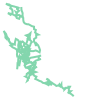

In [32]:
coords = [(arr[0], arr[1]) for arr in t_arr]
geometry.LineString(coords)

### Other sources
https://github.com/uoip/monoVO-python

In [21]:
import shutil

for i, src_path in enumerate(img_list[:470]):
    dest_path = os.path.join('/home/wroscoe/code/dk_notebooks/data/one_lap/', str(i).zfill(4)+'.jpg')
    shutil.copyfile(src_path, dest_path)